# <font color='magenta'>Fig2c_Healthy_Mild_and_Severe_from_Kernel_and_BG</font> 

This script is used to analyze the wheat kernel HSI data (VISNIR), written by Kshitiz Dhakal.

Healthy kernel pixels- 2000 data points
Mild kernel pixels- 2000 data points
Severe kernel pixels- 2000 data points

Total: 6000

Labels:
    Healthy kernel pixels- 0
Mild kernel pixels- 1
Severe kernel pixels- 2

### Packages and versions:

import sys #Python 3.8.6

import scipy #scipy: 1.6.0

import numpy #numpy: 1.18.5

import matplotlib #matplotlib: 3.3.3

import pandas #pandas: 1.2.1

import sklearn #sklearn: 1.0.2

import xgboost #xgboost: 1.5.1

import seaborn #seaborn: 0.11.1

### Import libraries and check their versions

In [1]:
import sys
print('Python: {}'.format(sys.version))
import scipy
print('scipy: {}'.format(scipy.__version__))
import numpy
print('numpy: {}'.format(numpy.__version__))
import matplotlib
import pandas
print('pandas: {}'.format(pandas.__version__))
import sklearn
print('sklearn: {}'.format(sklearn.__version__))
import xgboost
print('xgboost: {}'.format(xgboost.__version__))

Python: 3.8.6 | packaged by conda-forge | (default, Dec 26 2020, 04:30:06) [MSC v.1916 64 bit (AMD64)]
scipy: 1.6.0
numpy: 1.23.4
pandas: 1.2.1
sklearn: 1.0.2
xgboost: 1.5.1


### Load packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import spectral # spectral python (SPy) module for processing hyperspectral images
import spectral.io.envi as envi # load hyperspectral image with ENVI header files
import seaborn as sns
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
from statsmodels.formula.api import ols
from numpy import mean
from numpy import std
from pandas import read_csv
from xgboost import XGBClassifier
from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB #generative and supervised
from sklearn.neighbors import KNeighborsClassifier #discriminative and supervised
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #discriminative and supervised
from sklearn.neural_network import MLPClassifier #discriminative and supervised
from sklearn.cross_decomposition import PLSRegression #discriminative and supervised
from sklearn.ensemble import RandomForestClassifier as RF#discriminative and supervised
from sklearn import svm
from sklearn.svm import SVC #discriminative and supervised
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import KFold # for five fold cross validation
from sklearn.metrics import confusion_matrix # calcuate confusion matrix
from statannotations.Annotator import Annotator


### Load and pre-process the dataset having random pixel data from three classes of images

In [3]:
d = pd.read_csv('../Input/RF_refined_merged_selected200randomkernelsashealthymildsevere.csv', index_col=0)

#### Extract information from the orginal dataset

In [4]:
array = d.values # save all the values of d as array
labels = array[:,300] # save the labels
features = array[:,0:300] # save the reflectance values of classified pixels as features
features = features*4 # normalize features
wavelengths = d.columns[0:300] # save the column names as wavelengths

#### Rebuild the dataframe to visualize hyperspectral signatures

In [5]:
df = pd.DataFrame(features) #Create a new df having reflecance values only
df_wave = pd.DataFrame(wavelengths) # Add wavelengths in the df
df_wave.columns = ['Wavelength(nm)'] # Add a new column named Wavelength(nm) 
df.columns = df_wave['Wavelength(nm)'] # Add the previous column to the df
df['Label'] = labels # Add labels to the df
df.head() #Display head of df

Wavelength(nm),385.63,387.65,389.67,391.68,393.7,395.72,397.74,399.76,401.79,403.81,...,1009,1011.27,1013.54,1015.81,1018.08,1020.35,1022.63,1024.9,1027.18,Label
0,0.0,0.0000,0.3252,0.0,0.1996,0.0,0.1320,0.4240,0.2552,0.2980,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0
1,0.0,0.0000,0.0000,0.0,0.1984,0.0,0.1312,0.0000,0.0880,0.0000,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,1.3032,0.0,0.0
2,0.0,0.0000,0.0000,0.0,0.2000,0.0,0.1344,0.2164,0.0892,0.0724,...,0.8160,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0
3,0.0,0.3768,0.0000,0.0,0.1872,0.0,0.1332,0.3332,0.0880,0.2184,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0
4,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.1072,0.2540,0.1408,...,0.8264,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0


#### Create a dataframe df_m with three columns having Label, Wavelength(nm) and Reflectance 

In [6]:
df_m = df.melt(id_vars='Label', value_name='Reflectance') 
df_m.head() # Display df_m

,Label,Wavelength(nm),Reflectance
0,0.0,385.63,0.0
1,0.0,385.63,0.0
2,0.0,385.63,0.0
3,0.0,385.63,0.0
4,0.0,385.63,0.0


In [7]:
df_m.max()

Label                2.0
Wavelength(nm)    999.93
Reflectance       7.7416
dtype: object

#### Change the data type of the components of df_m to int and float for the convenience in plotting

In [8]:
df_m['Label']=df_m['Label'].astype(int)
df_m['Wavelength(nm)']=df_m['Wavelength(nm)'].astype(float)
df_m['Reflectance']=df_m['Reflectance'].astype(float)

### Plot the hyperspectral signatures(curves) of different classes

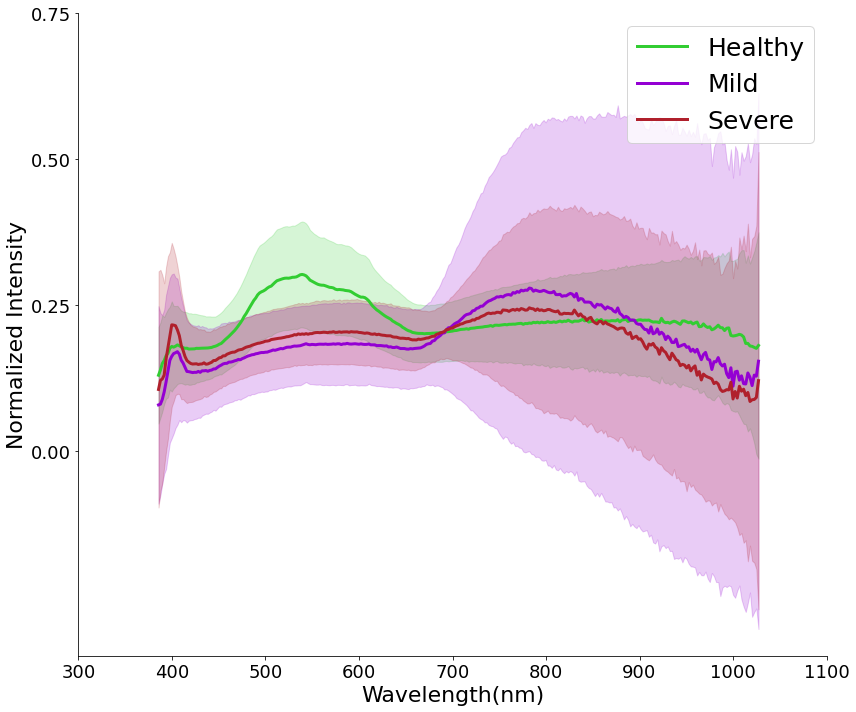

In [9]:
wheat_cmap = ListedColormap(['#32CD32','#9400D3','#B0202C'], name='organs') # hex code # Define the colormap mapping 0, and 1 to different colors
fig, ax = plt.subplots(figsize=(12, 10)) # Define a figure and a single axes object
ax = sns.lineplot(data=df_m, x='Wavelength(nm)', y='Reflectance', hue='Label', ci='sd',palette=wheat_cmap, linewidth=3)# Provide the data, axes, labels and other details for the graph
ax.set_xlim(300, 1100) # Set x-axis numbers
ax.set_yticks([0.00, 0.25, 0.50, 0.75]) # Set y-axis numbers
plt.setp(ax.get_xticklabels(), fontsize=18) #  Fontsize of the label numbers x-axis labels
plt.setp(ax.get_yticklabels(), fontsize=18) # Fontsize of the label numbers y-axis labels
ax.set_xlabel('Wavelength(nm)', fontsize=22) ## Set name and size of x axis label
ax.set_ylabel('Normalized Intensity', fontsize=22) # Set name and size of y axis label

ax.legend(frameon=True, fontsize=25, labels=['Healthy', 'Mild','Severe']) # Set the Index labels and put them inside the frame
ax.spines['right'].set_visible(False) # Remove x axis on right side
ax.spines['top'].set_visible(False) # Remove y axis on top
plt.tight_layout() # To cover much more space
plt.savefig('../Output/Fig2c_Curve_2classes_3final.pdf') # Save figure as pdf
plt.show() #Display the figure